## Load in the bridge dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
bridges_full = pd.read_excel('../data/raw/BMMS_overview.xlsx')
bridges_full

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.880,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694391,90.537574,interpolate
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694302,90.537707,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,Z8806,83.728,Box Culvert,LRP083a,.,1.78,D,110470,Lebukhali-Dumki-Boga-Bauphal-Kalaiya-Dashmina-...,83.728,7.6,1980.0,1.0,Barisal,Patuakhali,Barguna,Barguna,22.183448,90.299962,interpolate
20411,Z8810,3.981,Steel Beam & RCC Slab,LRP003b,.,27.20,D,113458,Bakerganj-Padrishibpur-Kathaltali-Subidkhali-B...,3.981,3.2,1979.0,5.0,Barisal,Barisal,Barisal,Barisal-1,22.519353,90.310063,interpolate
20412,Z8814,20.730,Baily with Steel Deck,LRP020b,Kalbari Bridge,30.50,D,121147,Barguna (Dakhin Ramna Kheya Ghat)-Dewatala-Mat...,20.730,NaN,NaN,NaN,Barisal,Barisal,Pirojpur,Kawkhali,22.282704,89.968512,interpolate
20413,Z8910,28.880,RCC Girder Bridge,LRP028a,Narainpur Bridge,9.50,D,119249,Barisal (Bairagirpool)-Tumchar-Bauphaul Road,28.880,NaN,NaN,NaN,Barisal,Patuakhali,Patuakhali,Patuakhali,22.510650,90.535314,interpolate


In [6]:
# Verify that there are no duplicate structure numbers 
bridges_full[bridges_full.duplicated('structureNr')]

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc


In [7]:
# From the previous assignment we know that bridges that are duplicated on either LRPName or coordinates, are mostly the same on other values as well. Some have minimal differences on bridge length or have missing values. Because of this, this function identifies duplicates based on only LRPName and chainage, for latter of which has been added as addittional check. 
def find_dupes_LRP(dataframe):
    df_copy = dataframe.copy()
    df_copy.sort_values(by=['LRPName', 'width'], inplace=True) #sort in such a way that the NaN values will be the bottom row
    df_copy.reset_index(inplace=True)
    # Check how many times each of the LRPs occur in the dataframe
    LRP_values = df_copy['LRPName'].value_counts()
    LRP_list = list(set((df_copy['LRPName'].to_list())))
    to_be_removed = []
    
    # For each LRP in the list, check if it has a duplicate, if so delete the duplicates while making sure that the worst bridge condition is kept
    for LRP in LRP_list:
        if LRP_values[LRP] == 2:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage']: 
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
            
        if LRP_values[LRP] == 3:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage'] == df_copy.loc[bridge1_index+2, 'chainage']:
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                con_bridge3 = df_copy.loc[bridge1_index+2, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                if con_bridge1 < con_bridge3:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge3
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+2, 'structureNr'])
            
        if LRP_values[LRP] == 4:
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['LRPName'] == LRP].index[0])
            if df_copy.loc[bridge1_index, 'chainage'] == df_copy.loc[bridge1_index+1, 'chainage'] == df_copy.loc[bridge1_index+2, 'chainage'] == df_copy.loc[bridge1_index+3, 'chainage']:
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                con_bridge3 = df_copy.loc[bridge1_index+2, 'condition']
                con_bridge4 = df_copy.loc[bridge1_index+3, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                if con_bridge1 < con_bridge3:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge3
                if con_bridge1 < con_bridge4:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge4
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+2, 'structureNr'])
                to_be_removed.append(df_copy.loc[bridge1_index+3, 'structureNr'])
    
    # Make a new dataframe containing only the cleaned bridges, and the ones that do not have a dupe
    df_cleaned = df_copy[~df_copy['structureNr'].isin(to_be_removed)]
    return df_cleaned

In [8]:
# Make a smaller dataframe to test if the code works the way it is supposed to
bridges_N1 = bridges_full[bridges_full['road']=='N1']
bridges_N1sort = bridges_N1.sort_values(by='LRPName')
bridges_N1sort.reset_index(inplace=True)
LRP_valuesN1 = bridges_N1sort['LRPName'].value_counts()
bridge_LRPN1 = bridges_N1sort[bridges_N1sort['LRPName'].isin(LRP_valuesN1[LRP_valuesN1>1].index)]
bridge_slice = bridge_LRPN1.head(8)
bridge_slice

,index,road,km,type,LRPName,name,length,condition,structureNr,roadName,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
2,2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
3,12706,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.00,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
11,9,N1,12.660,PC Girder Bridge,LRP013a,MADAN PUR (R),26.30,A,109841,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,9.20,2003.0,1.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.685583,90.551208,interpolate
12,10,N1,12.660,PC Girder Bridge,LRP013a,MADANPUR BRIDGE(L),26.30,A,109838,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,9.20,2003.0,1.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.685583,90.551208,interpolate
13,8,N1,12.660,PC Girder Bridge,LRP013a,Madanpur Bridge.(L),27.50,A,119897,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Vitikandi,23.685583,90.551208,interpolate
17,14588,N1,17.134,PC Girder Bridge,LRP017b,LANGOLBANDO PC GIDER BRIDGE,159.50,B,109808,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,17.80,1998.0,5.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.654426,90.576730,interpolate
18,12707,N1,17.134,RCC Girder Bridge,LRP017b,Langalbandh Bridge.,159.52,C,119909,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Vitikandi,23.654426,90.576730,interpolate
19,14590,N1,17.722,PC Girder Bridge,LRP018a,DARIKANDI BRIDGE (L),20.00,B,109853,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,...,9.20,2002.0,1.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.651571,90.581494,interpolate


In [9]:
df_slice_clean = find_dupes_LRP(bridge_slice)
df_slice_clean

,level_0,index,road,km,type,LRPName,name,length,condition,structureNr,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,3,12706,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.0,C,101102,...,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
2,11,9,N1,12.660,PC Girder Bridge,LRP013a,MADAN PUR (R),26.3,A,109841,...,9.20,2003.0,1.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.685583,90.551208,interpolate
5,17,14588,N1,17.134,PC Girder Bridge,LRP017b,LANGOLBANDO PC GIDER BRIDGE,159.5,C,109808,...,17.80,1998.0,5.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.654426,90.576730,interpolate
7,19,14590,N1,17.722,PC Girder Bridge,LRP018a,DARIKANDI BRIDGE (L),20.0,B,109853,...,9.20,2002.0,1.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.651571,90.581494,interpolate


The code is correct: only one of the duplicated bridges is kept, with the worst condition of the lot. In addition, the dataframe is sorted in such a way, that the kept bridge has a minimal amount of NaN-values. Lastly, LRPs that do not have a dupe, are not touched and therefor remain in the dataframe as such

## Start cleaning the bridges on the identified roads

In [10]:
roads_df = pd.read_csv('../data/semi-processed/identified_roads_final.csv')
roads_list = roads_df['road'].to_list()
roads = set(roads_list)
len(roads)

26

In [11]:
# To get an insight into how many bridges have been removed, check the original amount of bridges
bridges_df_list = []
for road in roads:
    dataframe = bridges_full[bridges_full['road'] == road]
    bridges_df_list.append(dataframe)
    df_bridges_full = pd.concat(bridges_df_list)

df_bridges_full

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
2860,R250,1.948,Box Culvert,LRP002c,GOTATIKOR BOX CULVERT,3.00,A,100484,Sylhet-Golapganj-Charkhai-Jakiganj Road,1.948,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.876110,91.881666,interpolate
2861,R250,4.083,Box Culvert,LRP004a,KUCHY BOX CULVERT,3.00,A,100485,Sylhet-Golapganj-Charkhai-Jakiganj Road,4.083,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.872902,91.902567,interpolate
2862,R250,5.432,Box Culvert,LRP006a,KUCHY BOX CULVERT,3.00,A,100486,Sylhet-Golapganj-Charkhai-Jakiganj Road,5.432,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.867792,91.914470,interpolate
2863,R250,8.107,Box Culvert,LRP008a,HELAL PUR BOX CULVERT,4.50,A,100489,Sylhet-Golapganj-Charkhai-Jakiganj Road,8.107,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.852237,91.934565,interpolate
2864,R250,12.648,Box Culvert,LRP013a,SUKNA BOX CULVERT,3.00,A,100487,Sylhet-Golapganj-Charkhai-Jakiganj Road,12.648,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.853910,91.976418,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16353,N204,10.785,Box Culvert,LRP012b,CHADCHURY CULVERT,4.60,C,104055,Jagadishpur-Chunarughat-Shaistaganj (old part),10.785,12.70,1986.0,2.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.128350,91.429691,interpolate
16354,N204,28.968,Box Culvert,LRP034b,NORPATI BOX CULVERT,3.12,C,104067,Jagadishpur-Chunarughat-Shaistaganj (old part),28.968,11.20,1978.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.227527,91.506074,interpolate
16355,N204,29.350,Box Culvert,LRP035a,NORPATI BOX CULVERT,24.20,C,104075,Jagadishpur-Chunarughat-Shaistaganj (old part),29.350,7.85,1986.0,5.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.230738,91.504886,interpolate
16356,N204,32.210,RCC Girder Bridge,LRP038b,Durgapur Bridge,17.85,C,120987,Jagadishpur-Chunarughat-Shaistaganj (old part),32.210,NaN,NaN,NaN,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.252372,91.491274,interpolate


In [12]:
df_bridges_full.isna().sum()

road                  0
km                    0
type                  0
LRPName               0
name                  0
length                1
condition             0
structureNr           0
roadName              0
chainage              0
width               463
constructionYear    463
spans               463
zone                  0
circle                0
division              0
sub-division          0
lat                   0
lon                   0
EstimatedLoc          0
dtype: int64

In [13]:
def correct_dupes_LRP(df, road_list):
    # Empty list to save in each cleaned dataframe per road
    full_cleaned_df_list = []
    
    # For each road, go trough the find_dupes_LRP function
    for road in road_list:
        dataframe = df[df['road'] == road]
        dataframe_cleaned = find_dupes_LRP(dataframe)
        full_cleaned_df_list.append(dataframe_cleaned)
    
    # Once the bridges on all the roads have been cleaned, concat the seperate road dataframes into one big dataframe again    
    df_cleaned = pd.concat(full_cleaned_df_list)
    return df_cleaned

In [14]:
cleaned_bridges_LRP = correct_dupes_LRP(bridges_full, roads)
cleaned_bridges_LRP

,index,road,km,type,LRPName,name,length,condition,structureNr,roadName,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,2860,R250,1.948,Box Culvert,LRP002c,GOTATIKOR BOX CULVERT,3.0,A,100484,Sylhet-Golapganj-Charkhai-Jakiganj Road,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.876110,91.881666,interpolate
1,2861,R250,4.083,Box Culvert,LRP004a,KUCHY BOX CULVERT,3.0,A,100485,Sylhet-Golapganj-Charkhai-Jakiganj Road,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.872902,91.902567,interpolate
2,2862,R250,5.432,Box Culvert,LRP006a,KUCHY BOX CULVERT,3.0,A,100486,Sylhet-Golapganj-Charkhai-Jakiganj Road,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.867792,91.914470,interpolate
3,2863,R250,8.107,Box Culvert,LRP008a,HELAL PUR BOX CULVERT,4.5,A,100489,Sylhet-Golapganj-Charkhai-Jakiganj Road,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.852237,91.934565,interpolate
4,2864,R250,12.648,Box Culvert,LRP013a,SUKNA BOX CULVERT,3.0,A,100487,Sylhet-Golapganj-Charkhai-Jakiganj Road,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.853910,91.976418,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,2618,N204,31.801,Box Culvert,LRP038a,DURGAPUR,1.5,A,104084,Jagadishpur-Chunarughat-Shaistaganj (old part),...,11.55,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.249896,91.493845,interpolate
31,2619,N204,32.210,RCC Girder Bridge,LRP038b,DORGAPUR RCC GIDER BRIDGE,17.8,C,104082,Jagadishpur-Chunarughat-Shaistaganj (old part),...,8.00,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.252372,91.491274,interpolate
33,2620,N204,33.550,Box Culvert,LRP040a,NEAR SHAIS TAGAMJ BOX CULVERT,4.5,A,104077,Jagadishpur-Chunarughat-Shaistaganj (old part),...,9.75,1988.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.261595,91.482321,interpolate
34,2621,N204,34.300,Slab Culvert,LRP041a,UBAHATA SLAB CULVERT,4.3,A,104085,Jagadishpur-Chunarughat-Shaistaganj (old part),...,9.70,1964.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.266583,91.476944,bcs1


In [15]:
cleaned_bridges_LRP.isna().sum()

index                0
road                 0
km                   0
type                 0
LRPName              0
name                 0
length               0
condition            0
structureNr          0
roadName             0
chainage             0
width               30
constructionYear    30
spans               30
zone                 0
circle               0
division             0
sub-division         0
lat                  0
lon                  0
EstimatedLoc         0
dtype: int64

In this first iteration of cleaning, 427 duplicated bridges got removed. With this, the amount of missing values also greatly decreased, from 426 entries with missing values to only 21. Duplicates can also occur if bridges are put on exactly the same place, but do not have the same LRP. These duplicates will also be handeled 

## Check for dupes based on coordinates

In [16]:
lat_values = cleaned_bridges_LRP['lat'].value_counts()
lat_values.value_counts()

count
1    2371
2      14
Name: count, dtype: int64

In [17]:
lon_values = cleaned_bridges_LRP['lon'].value_counts()
lon_values.value_counts()

count
1    2368
2      14
3       1
Name: count, dtype: int64

As there are duplicates in the coordinates, repeat the same steps as before. 

In [18]:
def find_dupes_coord(dataframe):
    df_copy = dataframe.copy()
    df_copy.sort_values(by=['lat', 'width'], inplace=True) #sort that the matching coordinates will be paired
    df_copy.reset_index(inplace=True)
    to_be_removed = []
    lat_values = df_copy['lat'].value_counts()
    lat_list = list(set((df_copy['lat'].to_list())))
    
    for lat in lat_list:
        if lat_values[lat] == 2:
            # For each duped latitude, check if the londitude also matches, before continuing
            bridge1_index = df_copy.index.get_loc(df_copy[df_copy['lat'] == lat].index[0])
            if df_copy.loc[bridge1_index, 'lon'] == df_copy.loc[bridge1_index+1, 'lon']: 
                con_bridge1 = df_copy.loc[bridge1_index, 'condition']
                con_bridge2 = df_copy.loc[bridge1_index+1, 'condition']
                if con_bridge1 < con_bridge2:
                    df_copy.at[bridge1_index, 'condition'] = con_bridge2
                to_be_removed.append(df_copy.loc[bridge1_index+1, 'structureNr'])
            
    df_cleaned = df_copy[~df_copy['structureNr'].isin(to_be_removed)]
    return df_cleaned

In [19]:
def correct_dupes_coord(df, road_list):
    full_cleaned_df_list = []
    
    for road in road_list:
        dataframe = df[df['road'] == road]
        dataframe_cleaned = find_dupes_coord(dataframe)
        full_cleaned_df_list.append(dataframe_cleaned)
        
    df_cleaned = pd.concat(full_cleaned_df_list)
    return df_cleaned

In [20]:
df_cleaned_coord = correct_dupes_coord(cleaned_bridges_LRP, roads)
df_cleaned_coord

,level_0,index,road,km,type,LRPName,name,length,condition,structureNr,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,3,2863,R250,8.107,Box Culvert,LRP008a,HELAL PUR BOX CULVERT,4.50,A,100489,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.852237,91.934565,interpolate
1,4,2864,R250,12.648,Box Culvert,LRP013a,SUKNA BOX CULVERT,3.00,A,100487,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.853910,91.976418,interpolate
2,7,2867,R250,15.317,Box Culvert,LRP015b,FULBARI BOX CULVERT,3.00,A,100491,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.854289,92.001478,interpolate
3,6,2866,R250,14.563,Box Culvert,LRP015a,FULBARI BOX CULVERT,3.00,A,100490,...,9.80,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.856098,91.994234,interpolate
4,5,2865,R250,14.032,Box Culvert,LRP014a,BOYTIKOL BOX CULVERT,3.00,A,100488,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.857246,91.989462,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,29,2617,N204,29.610,Box Culvert,LRP035c,CRIKOTA,1.55,A,104081,...,11.00,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.232763,91.504116,interpolate
28,30,2618,N204,31.801,Box Culvert,LRP038a,DURGAPUR,1.50,A,104084,...,11.55,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.249896,91.493845,interpolate
29,31,2619,N204,32.210,RCC Girder Bridge,LRP038b,DORGAPUR RCC GIDER BRIDGE,17.80,C,104082,...,8.00,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.252372,91.491274,interpolate
30,33,2620,N204,33.550,Box Culvert,LRP040a,NEAR SHAIS TAGAMJ BOX CULVERT,4.50,A,104077,...,9.75,1988.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.261595,91.482321,interpolate


In [21]:
df_cleaned_coord.isna().sum()

level_0              0
index                0
road                 0
km                   0
type                 0
LRPName              0
name                 0
length               0
condition            0
structureNr          0
roadName             0
chainage             0
width               18
constructionYear    18
spans               18
zone                 0
circle               0
division             0
sub-division         0
lat                  0
lon                  0
EstimatedLoc         0
dtype: int64

In this last and final iteration of cleaning, 11 bridges got removed. With this, the missing values got reduced to 17 entries

## Find out which bridge width corresponds to which amount of lanes
In order to make the probability of the bridges braking down in the model as accurate as possible, the amount of lanes each bridge has will be added based on the width of the bridge 

In [22]:
# Import the RMMS width files from the N1 and N2
N1_width = pd.read_table('../data/raw/N1.widths.processed.txt')
N2_width = pd.read_table('../data/raw/N2.widths.processed.txt')

In [23]:
N1_width

,roadNo,roadId,startChainage,endChainage,width,nrLanes
0,N1,1585,0.000,0.130,29.7,8
1,N1,1585,0.130,0.400,14.0,4
2,N1,1585,0.400,1.050,28.3,8
3,N1,1585,1.050,5.100,16.5,5
4,N1,1585,5.100,6.200,16.2,5
...,...,...,...,...,...,...
59,N1,1585,429.682,437.968,5.8,2
60,N1,1585,437.968,444.511,5.7,2
61,N1,1585,444.511,451.519,5.6,2
62,N1,1585,451.519,459.326,5.7,2


In [24]:
def find_min_max(dataframe, lanes):
    min, max = 100, 0 # pick numbers that will be overruled 
    df_lanes = dataframe[dataframe['nrLanes']==lanes]
    df_lanes.reset_index(inplace=True)
    for row in range(len(df_lanes)):
        if df_lanes.loc[row, 'width'] > max:
            max = df_lanes.at[row, 'width']
        if df_lanes.loc[row, 'width'] < min:
            min = df_lanes.at[row, 'width']
    return min, max

In [25]:
print('Information from N1 width files')
for lanes in range(9):
    min_lane, max_lane = find_min_max(N1_width, lanes)
    print(f'Lanes: {lanes} - min width: {min_lane} meters - max width: {max_lane} meters')

Information from N1 width files
Lanes: 0 - min width: 100 meters - max width: 0 meters
Lanes: 1 - min width: 100 meters - max width: 0 meters
Lanes: 2 - min width: 5.6 meters - max width: 8.2 meters
Lanes: 3 - min width: 10.3 meters - max width: 10.3 meters
Lanes: 4 - min width: 14.0 meters - max width: 15.0 meters
Lanes: 5 - min width: 15.3 meters - max width: 16.5 meters
Lanes: 6 - min width: 18.6 meters - max width: 46.9 meters
Lanes: 7 - min width: 100 meters - max width: 0 meters
Lanes: 8 - min width: 25.7 meters - max width: 29.7 meters


In [26]:
# There is an outlier in the 6 lanes maximum
N1_width[N1_width['nrLanes'] == 6] # so it has to be 18.9 meters

,roadNo,roadId,startChainage,endChainage,width,nrLanes
18,N1,1585,22.330,22.800,46.9,6
26,N1,1585,41.761,45.819,18.9,6
27,N1,1585,45.819,54.029,18.9,6
28,N1,1585,54.029,229.046,18.8,6
30,N1,1585,230.606,232.754,18.6,6


In [27]:
print('Information from N2 width files')
for lanes in range(9):
    min_lane, max_lane = find_min_max(N2_width, lanes)
    print(f'Lanes: {lanes} - min width: {min_lane} meters - max width: {max_lane} meters')

Information from N2 width files
Lanes: 0 - min width: 100 meters - max width: 0 meters
Lanes: 1 - min width: 100 meters - max width: 0 meters
Lanes: 2 - min width: 7.0 meters - max width: 8.0 meters
Lanes: 3 - min width: 8.0 meters - max width: 12.0 meters
Lanes: 4 - min width: 13.0 meters - max width: 140.0 meters
Lanes: 5 - min width: 17.2 meters - max width: 17.2 meters
Lanes: 6 - min width: 18.0 meters - max width: 21.0 meters
Lanes: 7 - min width: 100 meters - max width: 0 meters
Lanes: 8 - min width: 100 meters - max width: 0 meters


In [28]:
# There is an outlier in the 4 lanes maximum
N2_width[N2_width['nrLanes'] == 4] # so it has to be 17.0 meters

,roadNo,roadId,startChainage,endChainage,width,nrLanes
0,N2,1479,0.000,0.130,15.2,4
1,N2,1479,0.130,0.260,14.0,4
10,N2,1479,10.996,11.276,14.0,4
16,N2,1479,25.416,26.036,13.4,4
19,N2,1479,27.376,27.626,13.4,4
20,N2,1479,27.626,27.876,13.4,4
21,N2,1479,27.876,28.426,14.0,4
23,N2,1479,29.826,30.076,13.4,4
24,N2,1479,30.076,30.426,140.0,4
34,N2,1479,42.526,42.616,17.0,4


Based on the width values from the RMMS files, and the assumption that roads are always symmetrical, and the values from this official Bangladeshi source (https://www.rhd.gov.bd/Documents/RoadDesignAndSafety/Road%20Geometric%20Design%20Manual/Cross-Sections.pdf), which states that a roads needs to be 3.7m wide, we have landed on the following amount of lanes for width ranges <br>
<12m = 2 lanes <br>
12-18m = 4 lanes <br>
18-22m = 6 lanes <br>
22-30m = 8 lanes <br>

## Generate the amount of lanes per road

In [29]:
# For the bridges with missing values in the width column, check where on the road they are placed
df_cleaned_coord[df_cleaned_coord['width'].isna()]

,level_0,index,road,km,type,LRPName,name,length,condition,structureNr,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
38,20,2873,R250,32.593,RCC Girder Bridge,LRP033a,Kamar Gram Bridge,14.50,A,121823,...,NaN,NaN,NaN,Sylhet,Sylhet,Sylhet,Golapganj,24.906861,92.153000,interpolate
75,150,15762,N2,97.263,RCC Girder Bridge,LRP098a,Khilsima Bridge,27.03,C,121822,...,NaN,NaN,NaN,Comilla,Comilla,Brahmanbaria,Brahmanbaria,24.041972,91.213833,interpolate
89,72,15743,N2,58.035,RCC Girder Bridge,LRP058a,Bridge Over Arial,241.61,C,121824,...,NaN,NaN,NaN,Dhaka,Dhaka,Narsingdi,Shibpur,24.046916,90.862139,interpolate
335,390,772,N2,183.481,PC Girder Bridge,LRP184a,Minazpur Bridge,73.00,A,120959,...,NaN,NaN,NaN,Sylhet,Moulavi Bazar,Habiganj,Habigonj,24.599886,91.614736,interpolate
387,454,823,N2,224.112,PC Girder Bridge,LRP225a,Teli Bazar Bridge,40.80,A,120623,...,NaN,NaN,NaN,Sylhet,Sylhet,Sylhet,Sylhet,24.860883,91.846677,interpolate
36,47,5619,Z1042,31.775,RCC Girder Bridge,LRP034a,Shalpa Bridge,36.60,A,120374,...,NaN,NaN,NaN,Comilla,Comilla,Brahmanbaria,Bancharampur,23.702074,90.899216,interpolate
18,18,16292,R203,15.057,Truss with Steel Deck,LRP015a,Ramchandradi Bridge,148.11,C,120134,...,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.790643,90.708091,interpolate
30,21,17358,Z1048,10.195,Baily with Steel Deck,LRP011b,Gogor Bridge,15.25,C,120804,...,NaN,NaN,NaN,Comilla,Comilla,Comilla,Comilla,23.178267,91.197997,interpolate
15,52,2281,R151,31.573,Truss with Steel Deck,LRP033d,Gozaria Bridge,42.67,A,121390,...,NaN,NaN,NaN,Chittagong,Chittagong,Chittagong,Sitakunda,22.809674,91.718117,interpolate
21,44,16188,R151,26.086,Truss with Steel Deck,LRP026a,Datmara Bridge,18.38,C,121817,...,NaN,NaN,NaN,Chittagong,Chittagong,Chittagong,Sitakunda,22.852972,91.706056,interpolate


In [30]:
# Based on the LRPName and the chainge, none of the brides with NaN values are placed at the beginning of the end of their respective roads. This makes it safe to fill the missing values using forward fill, as there is no risk of filling the bridge with values from another road
df_cleaned_coord.ffill()

,level_0,index,road,km,type,LRPName,name,length,condition,structureNr,...,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,3,2863,R250,8.107,Box Culvert,LRP008a,HELAL PUR BOX CULVERT,4.50,A,100489,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.852237,91.934565,interpolate
1,4,2864,R250,12.648,Box Culvert,LRP013a,SUKNA BOX CULVERT,3.00,A,100487,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.853910,91.976418,interpolate
2,7,2867,R250,15.317,Box Culvert,LRP015b,FULBARI BOX CULVERT,3.00,A,100491,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.854289,92.001478,interpolate
3,6,2866,R250,14.563,Box Culvert,LRP015a,FULBARI BOX CULVERT,3.00,A,100490,...,9.80,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.856098,91.994234,interpolate
4,5,2865,R250,14.032,Box Culvert,LRP014a,BOYTIKOL BOX CULVERT,3.00,A,100488,...,9.70,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.857246,91.989462,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,29,2617,N204,29.610,Box Culvert,LRP035c,CRIKOTA,1.55,A,104081,...,11.00,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.232763,91.504116,interpolate
28,30,2618,N204,31.801,Box Culvert,LRP038a,DURGAPUR,1.50,A,104084,...,11.55,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.249896,91.493845,interpolate
29,31,2619,N204,32.210,RCC Girder Bridge,LRP038b,DORGAPUR RCC GIDER BRIDGE,17.80,C,104082,...,8.00,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.252372,91.491274,interpolate
30,33,2620,N204,33.550,Box Culvert,LRP040a,NEAR SHAIS TAGAMJ BOX CULVERT,4.50,A,104077,...,9.75,1988.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.261595,91.482321,interpolate


In [31]:
def add_lanes(df):
    dataframe = df.copy()
    dataframe.drop(columns=['level_0', 'index'], inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop(columns=['index'], inplace=True)
    for row in range(len(dataframe)):
         if dataframe.loc[row, 'width'] < 12:
            dataframe.at[row, 'lanes'] = 2
         elif (dataframe.loc[row, 'width'] >= 12) & (dataframe.loc[row, 'width'] < 18):
            dataframe.at[row, 'lanes'] = 4
         elif (dataframe.loc[row, 'width'] >= 18) & (dataframe.loc[row, 'width'] < 22):
            dataframe.at[row, 'lanes'] = 6
         else:
            dataframe.at[row, 'lanes'] = 8
    return dataframe

In [32]:
cleaned_bridges_final = add_lanes(df_cleaned_coord)
cleaned_bridges_final

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,lanes
0,R250,8.107,Box Culvert,LRP008a,HELAL PUR BOX CULVERT,4.50,A,100489,Sylhet-Golapganj-Charkhai-Jakiganj Road,8.107,...,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.852237,91.934565,interpolate,2.0
1,R250,12.648,Box Culvert,LRP013a,SUKNA BOX CULVERT,3.00,A,100487,Sylhet-Golapganj-Charkhai-Jakiganj Road,12.648,...,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.853910,91.976418,interpolate,2.0
2,R250,15.317,Box Culvert,LRP015b,FULBARI BOX CULVERT,3.00,A,100491,Sylhet-Golapganj-Charkhai-Jakiganj Road,15.317,...,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.854289,92.001478,interpolate,2.0
3,R250,14.563,Box Culvert,LRP015a,FULBARI BOX CULVERT,3.00,A,100490,Sylhet-Golapganj-Charkhai-Jakiganj Road,14.563,...,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.856098,91.994234,interpolate,2.0
4,R250,14.032,Box Culvert,LRP014a,BOYTIKOL BOX CULVERT,3.00,A,100488,Sylhet-Golapganj-Charkhai-Jakiganj Road,14.032,...,1995.0,1.0,Sylhet,Sylhet,Sylhet,Golapganj,24.857246,91.989462,interpolate,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,N204,29.610,Box Culvert,LRP035c,CRIKOTA,1.55,A,104081,Jagadishpur-Chunarughat-Shaistaganj (old part),29.610,...,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.232763,91.504116,interpolate,2.0
2381,N204,31.801,Box Culvert,LRP038a,DURGAPUR,1.50,A,104084,Jagadishpur-Chunarughat-Shaistaganj (old part),31.801,...,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.249896,91.493845,interpolate,2.0
2382,N204,32.210,RCC Girder Bridge,LRP038b,DORGAPUR RCC GIDER BRIDGE,17.80,C,104082,Jagadishpur-Chunarughat-Shaistaganj (old part),32.210,...,1965.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.252372,91.491274,interpolate,2.0
2383,N204,33.550,Box Culvert,LRP040a,NEAR SHAIS TAGAMJ BOX CULVERT,4.50,A,104077,Jagadishpur-Chunarughat-Shaistaganj (old part),33.550,...,1988.0,1.0,Sylhet,Moulavi Bazar,Habiganj,Shaistagonj,24.261595,91.482321,interpolate,2.0


In [33]:
cleaned_bridges_final.to_csv('../data/semi-processed/cleaned_bridges_final.csv')

### Check how many bridges got deleted in each cleaning iteration according to road type

In [34]:
# Check how many bridges, from which type of road did not get a match 
from collections import Counter

def identify_roads(df):
    dataframe = df.copy()
    dataframe['road'] = dataframe['road'].astype(str)
    road_list = dataframe['road'].to_list()
    
    road_letter = []
    road_number = []
    for road in road_list:
        letter = road[0]
        road_letter.append(letter)
        number = road[1:]
        road_number.append(number)
        
    print(f'The amount of bridges on Z, R and N roads respectivly: {Counter(road_letter).values()}')

In [35]:
identify_roads(df_bridges_full)

The amount of bridges on Z, R and N roads respectivly: dict_values([798, 1662, 402])


In [36]:
identify_roads(cleaned_bridges_LRP)

The amount of bridges on Z, R and N roads respectivly: dict_values([676, 1380, 343])


In [37]:
identify_roads(df_cleaned_coord)

The amount of bridges on Z, R and N roads respectivly: dict_values([676, 1366, 343])


## Lets make a beautiful visualisation to show the distribution of bridge contitions (to compare with the bonus)

In [38]:
df_cleaned_coord.condition.value_counts()

condition
A    1377
C     482
B     440
D      86
Name: count, dtype: int64

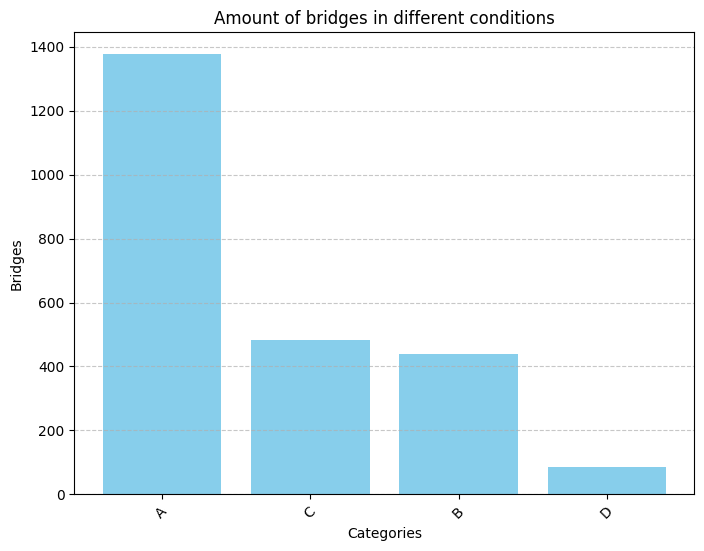

In [39]:
# Get value counts of the 'Category' column
value_counts = df_cleaned_coord['condition'].value_counts()


# Create bar plot using Pyplot
plt.figure(figsize=(8, 6))  
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.title('Amount of bridges in different conditions')
plt.xlabel('Categories')
plt.ylabel('Bridges')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

In [40]:
print(df_cleaned_coord.condition.value_counts()/df_cleaned_coord.condition.value_counts().sum())

condition
A    0.577358
C    0.202096
B    0.184486
D    0.036059
Name: count, dtype: float64
